# Part 2: ML

## Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import json

# import datetime, time
from datetime import timedelta, datetime, date, time

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import xgboost as xgb
from xgboost import cv
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold

# import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from catboost import CatBoostRegressor

from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import RFE # Рекурсивное устранение признаков (RFE)
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
import seaborn as sns
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
plt.style.use('fivethirtyeight')
# Подключаем форматирование Markdown
from IPython.display import Markdown

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

# Чтобы вычисления проходили на GPU необходимо чтобы tensorflow определил GPU.
# Как это сделать практически без боли написано здесь https://artificialintelligence.so/forums/discussion/how-to-install-tensorflow/
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices()
# Подключим видеокарту
!nvidia-smi -L
# !pip freeze > requirements.txt

Python       : 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.19.5
Tensorflow   : 2.5.0
Keras        : 2.5.0
Num GPUs Available:  1
GPU 0: NVIDIA GeForce RTX 2070 SUPER (UUID: GPU-f6280479-d16b-33b8-dd70-6511eca96aa8)


In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
isWorking = False # флаг для запуска кода

## Load dataset

In [3]:
dataset_path = 'dataset.csv'
# dataset.to_csv(dataset_path, index=False)
dataset = pd.read_csv(dataset_path)

# TODO при новой загрузке датасета слетает категориальный тип у столбцов
for column in dataset.select_dtypes(include='object'):
    dataset[column] = dataset[column].astype('category')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372514 entries, 0 to 372513
Data columns (total 38 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   status                     372514 non-null  category
 1   propertyType               372514 non-null  category
 2   baths                      372514 non-null  float64 
 3   fireplace                  372514 non-null  int64   
 4   city                       372514 non-null  category
 5   state                      372514 non-null  category
 6   stories                    372514 non-null  float64 
 7   target                     372514 non-null  int64   
 8   private_pool_union         372514 non-null  bool    
 9   street_type                372514 non-null  category
 10  has_address                372514 non-null  bool    
 11  hf_built_year              372514 non-null  int64   
 12  hf_remodeled_year          372514 non-null  int64   
 13  hf_heating    

In [6]:
display(dataset.head(5))

,status,propertyType,baths,fireplace,city,state,stories,target,private_pool_union,street_type,...,sk_gr_05,sk_gr_06,sk_gr_07,sk_gr_08,sk_gr_09,sk_gr_10,sk_gr_11,sk_gr_12,beds_num,beds_area
0,ACTIVE,SINGLE,3.5,1,SOUTHERN PINES,NC,0.0,418000,False,OTHER,...,3,3,3,3,3,3,3,3,4.0,0.0
1,FOR SALE,SINGLE,3.0,0,SPOKANE VALLEY,WA,2.0,310000,False,AVENUE,...,2,2,2,2,1,1,1,1,3.0,0.0
2,FOR SALE,SINGLE,2.0,1,LOS ANGELES,CA,1.0,2895000,True,ROAD,...,1,1,1,1,1,1,1,1,3.0,0.0
3,FOR SALE,SINGLE,7.0,1,DALLAS,TX,3.0,2395000,False,AVENUE,...,1,1,1,1,1,1,1,1,5.0,0.0
4,FOR SALE,LAND,1.0,0,PALM BAY,FL,0.0,5000,False,STREET,...,1,1,1,1,1,1,1,1,0.0,0.0


### Create dummy variables

In [100]:
dummy_cols = dataset.select_dtypes(include=['bool']).columns
dummy_cols

Index(['private_pool_union', 'has_address', 'hf_has_remodeled'], dtype='object')

In [101]:
# Попробуем некоторые столбцы сделать dummy переменными
# ['fireplace','beds','stories','PrivatePool','status_rating','property_rating',
#                                 'num_prop_descr','street_type','num_bath', 'city_rating','state_rating'] 
df = pd.get_dummies(dataset, columns=dummy_cols, drop_first=True)

display(df.head(5))
display(df.info())
dataset = df

,status,propertyType,baths,fireplace,city,state,stories,target,street_type,hf_built_year,...,sk_gr_08,sk_gr_09,sk_gr_10,sk_gr_11,sk_gr_12,beds_num,beds_area,private_pool_union_True,has_address_True,hf_has_remodeled_True
0,ACTIVE,SINGLE,3.5,1,SOUTHERN PINES,NC,0.0,418000,OTHER,2019,...,3,3,3,3,3,4.0,0.0,0,1,1
1,FOR SALE,SINGLE,3.0,0,SPOKANE VALLEY,WA,2.0,310000,AVENUE,2019,...,2,1,1,1,1,3.0,0.0,0,1,1
2,FOR SALE,SINGLE,2.0,1,LOS ANGELES,CA,1.0,2895000,ROAD,1961,...,1,1,1,1,1,3.0,0.0,1,1,1
3,FOR SALE,SINGLE,7.0,1,DALLAS,TX,3.0,2395000,AVENUE,2006,...,1,1,1,1,1,5.0,0.0,0,1,1
4,FOR SALE,LAND,1.0,0,PALM BAY,FL,0.0,5000,STREET,0,...,1,1,1,1,1,0.0,0.0,0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372514 entries, 0 to 372513
Data columns (total 38 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   status                     372514 non-null  category
 1   propertyType               372514 non-null  category
 2   baths                      372514 non-null  float64 
 3   fireplace                  372514 non-null  int64   
 4   city                       372514 non-null  category
 5   state                      372514 non-null  category
 6   stories                    372514 non-null  float64 
 7   target                     372514 non-null  int64   
 8   street_type                372514 non-null  category
 9   hf_built_year              372514 non-null  int64   
 10  hf_remodeled_year          372514 non-null  int64   
 11  hf_heating                 372514 non-null  category
 12  hf_cooling                 372514 non-null  category
 13  hf_parking    

None

### Кодирование категориальных признаков

In [102]:
# Применим LabelEncoder ко всему набору категориальных признаков
# TODO нужно попробовать другие энкодеры
label_encoder = LabelEncoder()
for column in dataset.select_dtypes(include='category'):
    dataset[column] = label_encoder.fit_transform(dataset[column])

#Закодируем категориальные колонки   
# for colum in cat_cols:
#     df[colum] = df[colum].astype('category').cat.codes
dataset.head(5)

,status,propertyType,baths,fireplace,city,state,stories,target,street_type,hf_built_year,...,sk_gr_08,sk_gr_09,sk_gr_10,sk_gr_11,sk_gr_12,beds_num,beds_area,private_pool_union_True,has_address_True,hf_has_remodeled_True
0,0,17,3.5,1,1601,20,0.0,418000,8,2019,...,3,3,3,3,3,4.0,0.0,0,1,1
1,5,17,3.0,0,1611,36,2.0,310000,0,2019,...,2,1,1,1,1,3.0,0.0,0,1,1
2,5,17,2.0,1,974,3,1.0,2895000,11,1961,...,1,1,1,1,1,3.0,0.0,1,1,1
3,5,17,7.0,1,404,32,3.0,2395000,0,2006,...,1,1,1,1,1,5.0,0.0,0,1,1
4,5,9,1.0,0,1259,7,0.0,5000,12,0,...,1,1,1,1,1,0.0,0.0,0,1,0


### Корреляция признаков

In [103]:
from matplotlib.ticker import PercentFormatter
def heatmap_custom(dataframe, figsize=(20,15)):
    '''heatmap - корреляция Пирсона с дополнительными настроками'''
    matrix = np.triu(dataframe.corr()) # для отображения диагональной матрицы
    #matrix = dataframe.corr().values
    #display(matrix)
    # matrix = np.array(dataframe.corr())
    fig, ax = plt.subplots(figsize=figsize)
    sns_plot = sns.heatmap(
        #dataframe.corr().abs(),
        dataframe.corr(),
        square=False, annot=True, 
        fmt=".0%", linewidths=0.1, cmap="tab20", annot_kws={'size':12}, #Set1 tab20
        center=0, vmin=0, vmax=1, mask=matrix);
    cbar = ax.collections[0].colorbar
    cbar.ax.yaxis.set_major_formatter(PercentFormatter(1, 0))
    plt.tight_layout()
#     sns_plot.savefig("heatmap.png")

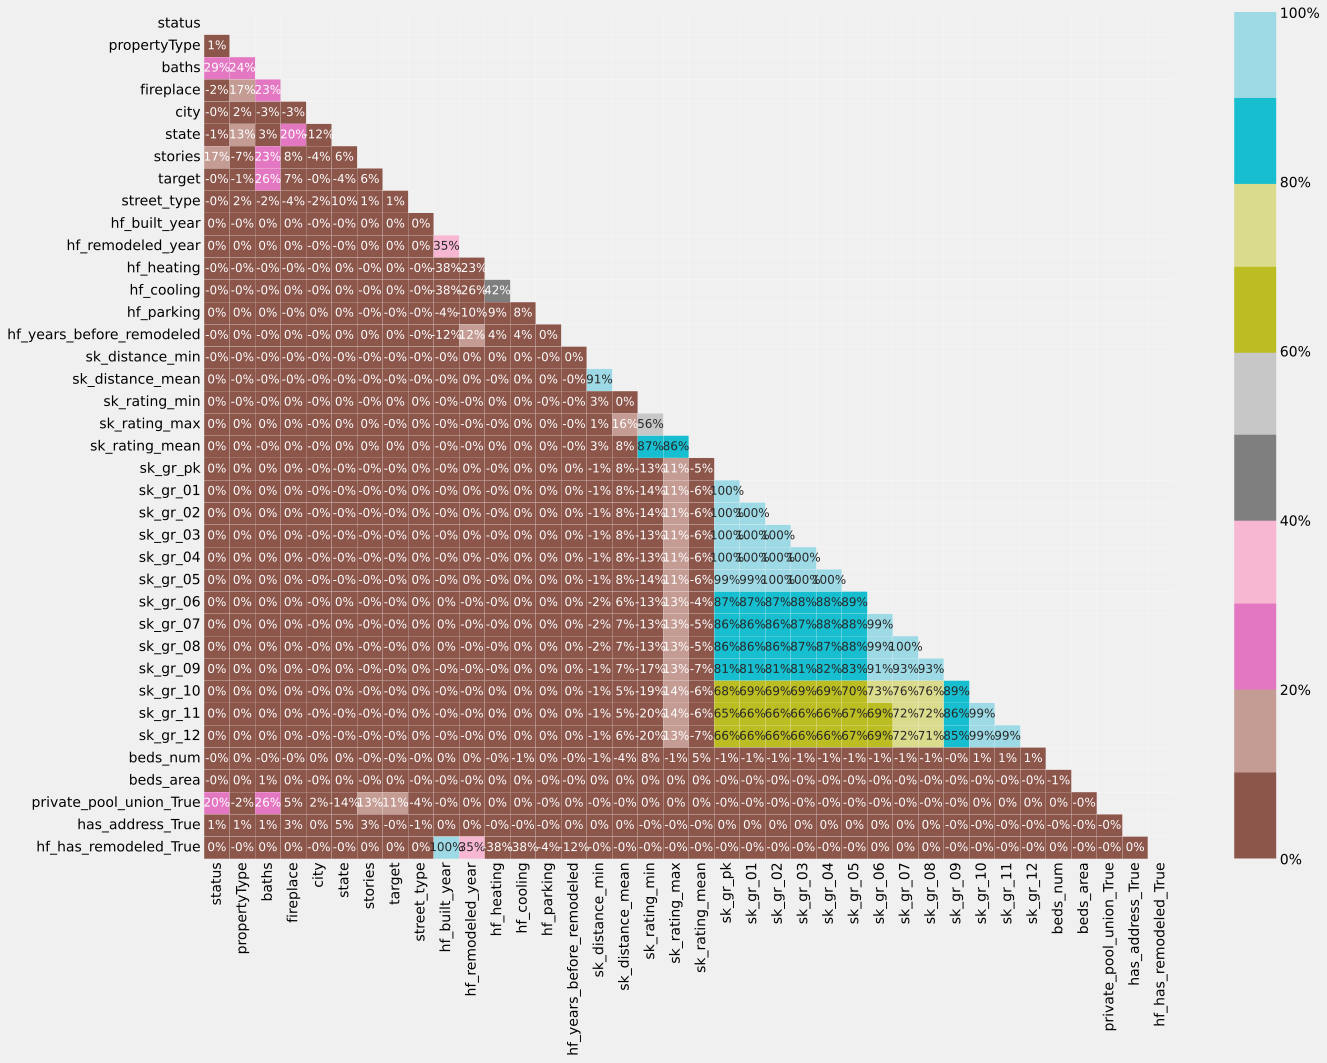

In [104]:
# Посмотрим на корреляцию признаков
# heatmap_custom(data_fe[data_fe.train][[x for x in data_fe.columns if x not in ['train']]])
heatmap_custom(dataset)

# cor = dataset.corr()
# plt.figure(figsize=(20,20))
# sns.heatmap(cor, cmap='Set1', annot=True);

In [105]:
X = dataset.drop(['target'], axis=1)
# y =  dataset['target'] # <--- target
y =  np.log1p(dataset['target']) # <--- target

## Feature elimination

In [106]:
# Значение метрики MAPE лучше, если признаки оставить (для модели CatBoostRegressor)
# поэтому признаки не удаляем, темболее на kaggle для этого часто не хватает памяти
feat_importances = X.columns
## отберем ненужные признаки с помощью случайного леса

# model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
# model.fit(X, y)
# feat_importances = pd.Series(model.feature_importances_, index=X.columns)
# feat_importances.nlargest(15).plot(kind='barh', figsize=(15,10), color=['orange']);
# plt.tight_layout()
# feat_importances = feat_importances.index
# X.info()

### Feature ranking with recursive feature elimination (RFE)

In [107]:
# Рекурсивное устранение признаков (RFE) основывается на повторяющемся конструировании модели и 
# выборе лучше всех или хуже всех выполняемого признака, отделения этого признака и повторения цикла с оставшимися. 
# Этот процесс применяется, пока в наборе данных не закончатся признаки. 
# Цель RFE заключается в отборе признаков посредством рекурсивного рассмотрения всё меньшего и меньшего их набора.
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

is_RFE = False
if is_RFE:
    y_int = y.astype(int)
    # После применение алгоритма половина признаков удалено, посмотрим как это повлияет на итоговый результат
    columns = feat_importances
    print(f'List columns old (len={len(columns)}):')
    # display(pd.Series(columns))

    logreg = LogisticRegression()
    rfe = RFE(logreg, n_features_to_select=None)
    rfe = rfe.fit(X, y_int)
    # print(rfe.support_)
    # print(rfe.ranking_)

    columns_with_rfe=[value for (index, value) in enumerate(columns) if rfe.support_[index]]
    print(f'\nList columns with rfe (len={len(columns_with_rfe)}):')
    # display(pd.Series(columns_with_rfe))
    feat_importances = columns_with_rfe
#     data_fe_with_dummies = data_fe_with_dummies[[*columns_with_rfe, *['default','train']]]

In [108]:
print(feat_importances, len(feat_importances))
# List columns old (len=37):
# ['status', 'propertyType', 'baths', 'city', 'state', 'street_type', 'hf_built_year', 'hf_remodeled_year', 'hf_heating', 'hf_parking', 'hf_years_before_remodeled', 'sk_distance_mean', 'sk_rating_min', 'sk_rating_max', 'sk_rating_mean', 'sk_gr_05', 'beds_num', 'beds_area'] 18

Index(['status', 'propertyType', 'baths', 'fireplace', 'city', 'state',
       'stories', 'street_type', 'hf_built_year', 'hf_remodeled_year',
       'hf_heating', 'hf_cooling', 'hf_parking', 'hf_years_before_remodeled',
       'sk_distance_min', 'sk_distance_mean', 'sk_rating_min', 'sk_rating_max',
       'sk_rating_mean', 'sk_gr_pk', 'sk_gr_01', 'sk_gr_02', 'sk_gr_03',
       'sk_gr_04', 'sk_gr_05', 'sk_gr_06', 'sk_gr_07', 'sk_gr_08', 'sk_gr_09',
       'sk_gr_10', 'sk_gr_11', 'sk_gr_12', 'beds_num', 'beds_area',
       'private_pool_union_True', 'has_address_True', 'hf_has_remodeled_True'],
      dtype='object') 37


In [109]:
X = X[feat_importances]

In [110]:
# # Отобразим boxplot для номинативных переменных
# object_features = dataset.select_dtypes(include=['category','bool']).columns

# fig, axes = plt.subplots(nrows=int(len(object_features)/2)+1, ncols=2, figsize=(10, 32))

# for index, col in enumerate(object_features):
#     get_boxplot(dataset, col,'target', axes[int(index / 2), index % 2])

## Split data

Разобъем данные
* train 70%
* test 15%
* validation 15%

In [111]:
# split данных
X_train, X_for_test, y_train, y_for_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_for_test, y_for_test, test_size=0.5, random_state=RANDOM_SEED)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_train.shape)
# print(f"Количество строк в y_train по классам: {np.bincount(y_train)}")
# print(f"Количество строк в y_test по классам: {np.bincount(y_test)}")
# print(f"Количество строк в y_test по классам: {np.bincount(y_val)}")

(260759, 37) (260759,) (55877, 37) (55877,) (55878, 37) (260759,)


In [112]:
# Код построений графиков вешает блокнот
# doLog=True
# fig ,ax = plt.subplots(3,1)
# ax1, ax2, ax3 = ax.flatten()
# ax1.set_title('y_train')

# y_train.hist(figsize=(15,10), log=doLog, bins=100, ax=ax1);

# ax2.set_title('y_test')
# y_test.hist(figsize=(15,10), log=doLog, bins=100, ax=ax2);

# ax3.set_title('y_val')
# y_val.hist(figsize=(15,10), log=doLog, bins=100, ax=ax3);
# plt.tight_layout()
# y_train.plot(figsize=(12,5));
# plt.tight_layout()

### Scaling

In [113]:
# Произведем маштабирование числовых признаков
# MinMaxScaler не искажает расстояния между значениями в каждой функции.
#согласное статье https://www.machinelearningmastery.ru/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02/

scaler = MinMaxScaler() 
# scaler = StandardScaler()
# scaler = RobustScaler()

num_cols = X.select_dtypes(include=['number']).columns
num_cols = [x for x in num_cols if x not in ['target']]

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [114]:
X_train.head()

,status,propertyType,baths,fireplace,city,state,stories,street_type,hf_built_year,hf_remodeled_year,...,sk_gr_08,sk_gr_09,sk_gr_10,sk_gr_11,sk_gr_12,beds_num,beds_area,private_pool_union_True,has_address_True,hf_has_remodeled_True
264086,0.000000,0.85,0.142857,0.000000,0.554154,0.189189,0.000000,0.307692,0.968889,0.970807,...,0.050847,0.060606,0.071429,0.071429,0.071429,0.000000,0.0,0.0,1.0,1.0
46928,0.454545,0.85,0.285714,0.083333,0.952156,0.189189,0.111111,0.076923,0.990123,0.992083,...,0.016949,0.060606,0.142857,0.142857,0.142857,0.000000,0.0,1.0,1.0,1.0
242510,0.818182,0.35,0.142857,0.083333,0.403260,0.864865,0.111111,0.923077,0.977284,0.000000,...,0.033898,0.030303,0.071429,0.071429,0.071429,0.006944,0.0,0.0,1.0,1.0
141131,0.454545,0.85,0.285714,0.083333,0.677182,0.189189,0.111111,0.307692,0.994568,0.000000,...,0.016949,0.030303,0.071429,0.071429,0.071429,0.020833,0.0,0.0,1.0,1.0
7255,0.454545,0.85,0.428571,0.083333,0.722923,0.540541,0.000000,0.307692,0.996543,0.000000,...,0.033898,0.030303,0.071429,0.071429,0.071429,0.020833,0.0,0.0,1.0,1.0


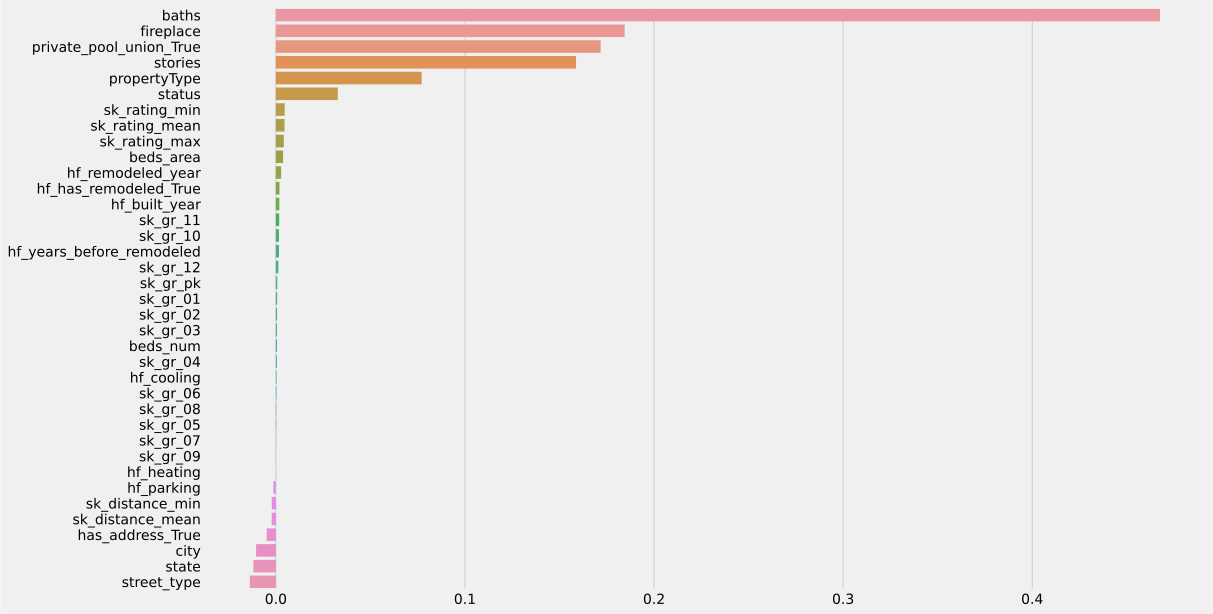

In [115]:
# Посмотрим на корреляцию с целевой переменной
correlations = X_train.corrwith(y_train).sort_values(ascending=False)
plt.figure(figsize=(16, 10))
plot = sns.barplot(y=correlations.index, x=correlations)

## ML

### Выбранные метрики:

* **MAE** - средний модуль отклонения.
* **MAPE** средний процент отклонения.
* **R2** Коэффициент детерминации - это доля дисперсии зависимой переменной, объясняемая рассматриваемой моделью зависимости. Коэффициент можно рассматривать как универсальную меру зависимости одной случайной величины от множества других.

### Интерпретация R2:

* Коэффициент детерминации принимает значения от 0 до 1.
* Для приемлемых моделей коэффициент должен быть не меньше 50%.
* Модели с коэффициентом детерминации выше 80 % можно признать достаточно хорошими.
* Коэффициент может быть отрицательным, это говорит о крайней неадекватности модели: простое среднее приближает лучше.

> Стоит отметить, что коэффициент детерминации довольно часто используется в научных исследованиях (особенно в социальных науках), однако в практических бизнес-задачах он часто бывает **несостоятелен для оценки качества модели**, и об этом необходимо помнить. Он может принимать очень низкие значения при полностью верной модели. И, наоборот, приближаться к единице при неверной модели.

In [116]:
def metrics_print(y_test, y_pred):
    print(f"MAE: {mean_absolute_error(y_test, y_pred).round(2)}$")
    print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred).round(2)}%")
    #Вычисляем коэффициент детерминации:
    print(f"R2: {r2_score(y_test, y_pred).round(2)}%")

### Baseline prediction

In [117]:
# https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
# "Learn" the mean from the training data
mean_train = np.mean(y_train)
# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train
# Compute MAE
metrics_print(y_test, baseline_predictions)
metrics_print(np.expm1(y_test), np.expm1(baseline_predictions))
# MAE: 582851.42$
# MAPE: 7.13%

# 18 Признаков с log 
# MAE: 470363.68$
# MAPE: 3.28%
# R2: -0.03%

MAE: 0.84$
MAPE: 0.07%
R2: -0.0%
MAE: 470363.68$
MAPE: 3.28%
R2: -0.03%


### Model "LinearRegression"

Построим базовую модель LinearRegression и посмотрим на метрики.

In [118]:
%%time
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
metrics_print(y_test, y_pred)
metrics_print(np.expm1(y_test), np.expm1(y_pred))
# Базовая модель 
# MAE: 557167.49$
# MAPE: 3.84%

# 37 признаков log
# MAE: 415583.13$
# MAPE: 2.21%
# R2: 0.08%

# 18 признаков log
# MAE: 418685.74$
# MAPE: 2.31%
# R2: 0.08%

MAE: 0.73$
MAPE: 0.06%
R2: 0.25%
MAE: 415583.13$
MAPE: 2.21%
R2: 0.08%
Wall time: 434 ms


Попытка попробовать DBSCAN

In [119]:
# https://towardsdatascience.com/dbscan-clustering-algorithm-how-to-build-powerful-density-based-models-21d9961c4cec

# Мы будем использовать следующие 3 функции для кластеризации наблюдений:
# «Расстояние X3 до ближайшей станции метро»
# «Возраст дома X2»
# «Цена дома Y за единицу площади».

# X_scaled = X_train[['baths' , 'private_pool_union_True' , 'hf_built_year']]

### Model "CatBoost"
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)  

In [120]:
%%time
if (False):
        model = CatBoostRegressor(iterations = 5000,
                                random_seed = RANDOM_SEED,
                                eval_metric='MAPE',
                                custom_metric=['RMSE', 'MAE'], #'R2',
                                silent=False,
                                task_type="GPU",
                                od_wait=500,
                                learning_rate=0.05, # 0.5 эти параметры немного ухудшают результат
                                depth=10,
        #                           l2_leaf_reg=8, 
        #                           random_strength=0.3
                                )

        model.fit(
                X_train, y_train,
                #cat_features=X.columns.get_indexer(X.select_dtypes(include='category').columns),
                eval_set=( X_val, y_val),
                verbose_eval=100,
                use_best_model=True,
                #plot=True
                )

        y_pred = model.predict(X_test)
        metrics_print(y_test, y_pred)
        metrics_print(np.expm1(y_test), np.expm1(y_pred))
        # MAE: 365325.84$
        # MAPE: 2.59%

        # MAE: 365611.36$
        # MAPE: 2.62%

        # MAE: 359660.2$
        # MAPE: 2.53%
        
        # 37 признаков log
        # MAE: 297449.66$
        # MAPE: 1.05%
        # R2: 0.37%
        
        # 18 признаков log
        # MAE: 306076.64$
        # MAPE: 1.1%
        # R2: 0.36%

Wall time: 0 ns


### Model "XGBoost"

Training and Tuning an XGBoost model

In [121]:
num_boost_round = 1000

In [123]:
# https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

params = {
    'objective': 'reg:squarederror',
     'booster': 'gbtree',
    'colsample_bytree': 0.3,
    'learning_rate': 0.1,
    'max_depth': 5, 
    'alpha': 10,
    'eval_metric': ['mae', 'mape']
 }

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

model = xgb.train(
    params,
    dval,
    num_boost_round=num_boost_round,
    evals=[(dval, "Test")],
    early_stopping_rounds=10,
    verbose_eval=100,
)

y_pred = model.predict(dtest)
metrics_print(y_test, y_pred)
metrics_print(np.expm1(y_test), np.expm1(y_pred))
# print(dir(model))
# print("Best MAE: {:.2f} with {} rounds".format(
#                  model.best_score,
#                  model.best_iteration+1))

# MAE: 424533.49$
# MAPE: 3.64%

# 37 признаков log
# MAE: 312491.52$
# MAPE: 1.08%
# R2: 0.32%

[0]	Test-mae:10.92682	Test-mape:0.86319
[100]	Test-mae:0.52027	Test-mape:0.04347
[200]	Test-mae:0.49397	Test-mape:0.04114
[300]	Test-mae:0.48037	Test-mape:0.03998
[400]	Test-mae:0.46895	Test-mape:0.03897
[500]	Test-mae:0.46106	Test-mape:0.03831
[600]	Test-mae:0.45379	Test-mape:0.03768
[700]	Test-mae:0.44725	Test-mape:0.03711
[800]	Test-mae:0.44165	Test-mape:0.03663
[900]	Test-mae:0.43678	Test-mape:0.03621
[999]	Test-mae:0.43227	Test-mape:0.03582
MAE: 0.48$
MAPE: 0.04%
R2: 0.67%
MAE: 312491.52$
MAPE: 1.08%
R2: 0.32%


Using XGBoost’s CV

In [132]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=RANDOM_SEED,
    nfold=5,
    metrics={'mae', 'mape'},
    early_stopping_rounds=10
)

In [133]:
# print(cv_results)
print(f"MAE: {np.round(cv_results['test-mae-mean'].min(), 2)}$, MAPE: {np.round(cv_results['test-mape-mean'].mean(), 2)}%")

# MAE: 588947.09$, MAPE: 4.41%

MAE: 588947.09$, MAPE: 4.41%


In [134]:
# https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
# You can try wider intervals with a larger step between
# each value and then narrow it down. Here after several
# iteration I found that the optimal value was in the
# following ranges.
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [135]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=RANDOM_SEED,
        nfold=5,
        metrics={'mae', 'mape'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    mean_mape = cv_results['test-mape-mean'].min()
    boost_rounds_mae = cv_results['test-mae-mean'].argmin()
    boost_rounds_mape = cv_results['test-mape-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds_mae))
    print("\tMAPE {} for {} rounds".format(mean_mape, boost_rounds_mape))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth, min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=9, min_child_weight=5
	MAE 589942.725 for 0 rounds
	MAPE 4.3966541999999995 for 0 rounds
CV with max_depth=9, min_child_weight=6
	MAE 589915.6125 for 0 rounds
	MAPE 4.396647 for 0 rounds
CV with max_depth=9, min_child_weight=7
	MAE 589904.725 for 0 rounds
	MAPE 4.3969534 for 0 rounds
CV with max_depth=10, min_child_weight=5
	MAE 590392.9875 for 0 rounds
	MAPE 4.3987966 for 0 rounds
CV with max_depth=10, min_child_weight=6
	MAE 590345.55 for 0 rounds
	MAPE 4.3988912 for 0 rounds
CV with max_depth=10, min_child_weight=7
	MAE 590301.6875 for 0 rounds
	MAPE 4.3989002 for 0 rounds
CV with max_depth=11, min_child_weight=5
	MAE 590910.95 for 0 rounds
	MAPE 4.652768 for 0 rounds
CV with max_depth=11, min_child_weight=6
	MAE 590854.025 for 0 rounds
	MAPE 4.6524958 for 0 rounds
CV with max_depth=11, min_child_weight=7
	MAE 590764.075 for 0 rounds
	MAPE 4.652279600000001 for 0 rounds
Best params: 9, 7, MAE: 589904.725


Подобрали параметры: Best params: 9, 7, MAE: 589904.73 MAPE 4.65

In [136]:
params['max_depth'] = 9
params['min_child_weight'] = 7

In [137]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]
# gridsearch_params

In [138]:
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=RANDOM_SEED,
        nfold=5,
        metrics={'mae', 'mape'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    mean_mape = cv_results['test-mape-mean'].min()
    boost_rounds_mae = cv_results['test-mae-mean'].argmin()
    boost_rounds_mape = cv_results['test-mape-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds_mae))
    print("\tMAPE {} for {} rounds".format(mean_mape, boost_rounds_mape))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample, colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
	MAE 586000.8125 for 0 rounds
	MAPE 4.8728442 for 0 rounds
CV with subsample=1.0, colsample=0.9
	MAE 585766.6375 for 0 rounds
	MAPE 3.4216065999999996 for 0 rounds
CV with subsample=1.0, colsample=0.8
	MAE 585796.525 for 0 rounds
	MAPE 3.4216236 for 0 rounds
CV with subsample=1.0, colsample=0.7
	MAE 586954.4125 for 0 rounds
	MAPE 3.3245792 for 0 rounds
CV with subsample=0.9, colsample=1.0
	MAE 586108.2 for 0 rounds
	MAPE 4.0824998 for 0 rounds
CV with subsample=0.9, colsample=0.9
	MAE 585930.8 for 0 rounds
	MAPE 3.4426622 for 0 rounds
CV with subsample=0.9, colsample=0.8
	MAE 585939.9375 for 0 rounds
	MAPE 3.442671 for 0 rounds
CV with subsample=0.9, colsample=0.7
	MAE 587083.65 for 0 rounds
	MAPE 3.1552664000000004 for 0 rounds
CV with subsample=0.8, colsample=1.0
	MAE 586172.85 for 0 rounds
	MAPE 4.0657336 for 0 rounds
CV with subsample=0.8, colsample=0.9
	MAE 585935.2375 for 0 rounds
	MAPE 3.0845346 for 0 rounds
CV with subsample=0.8, colsample=0

Подобрали параметры: Best params: 1., 0.9, MAE: 585766.64 MAPE 3.51

In [139]:
params['subsample'] = 1.
params['colsample_bytree'] = 0.9

In [140]:
params

{'objective': 'reg:squarederror',
 'booster': 'gbtree',
 'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'max_depth': 9,
 'alpha': 10,
 'eval_metric': ['mae', 'mape'],
 'min_child_weight': 7,
 'subsample': 1.0}

In [141]:
%time
# This can take some time…
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=RANDOM_SEED,
        nfold=5,
        metrics={'mae', 'mape'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    mean_mape = cv_results['test-mape-mean'].min()
    boost_rounds_mae = cv_results['test-mae-mean'].argmin()
    boost_rounds_mape = cv_results['test-mape-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds_mae))
    print("\tMAPE {} for {} rounds".format(mean_mape, boost_rounds_mape))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params , min_mae))

Wall time: 0 ns
CV with eta=0.3
	MAE 585766.6375 for 0 rounds
	MAPE 3.4216065999999996 for 0 rounds
CV with eta=0.2
	MAE 585766.6375 for 0 rounds
	MAPE 3.4216065999999996 for 0 rounds
CV with eta=0.1
	MAE 585766.6375 for 0 rounds
	MAPE 3.4216065999999996 for 0 rounds
CV with eta=0.05
	MAE 585766.6375 for 0 rounds
	MAPE 3.4216065999999996 for 0 rounds
CV with eta=0.01
	MAE 585766.6375 for 0 rounds
	MAPE 3.4216065999999996 for 0 rounds
CV with eta=0.005
	MAE 585766.6375 for 0 rounds
	MAPE 3.4216065999999996 for 0 rounds
Best params: 0.3, MAE: 585766.6375


Подобрали параметры: Best params: 0.3, MAE: 585766.64 MAPE 3.42

In [142]:
params['eta'] = 0.3

Результат подбора параметров

In [143]:
params

{'objective': 'reg:squarederror',
 'booster': 'gbtree',
 'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'max_depth': 9,
 'alpha': 10,
 'eval_metric': ['mae', 'mape'],
 'min_child_weight': 7,
 'subsample': 1.0,
 'eta': 0.3}

In [124]:
params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    'colsample_bytree': 0.9,
    'learning_rate': 0.1,
    'max_depth': 9,
    'alpha': 10,
    'eval_metric': ['mae', 'mape'],
    'min_child_weight': 7,
    'subsample': 1.0,
    'eta': 0.3
}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)
y_pred = model.predict(dtest)
metrics_print(y_test, y_pred)
metrics_print(np.expm1(y_test), np.expm1(y_pred))
# До подбора гиперпараметров
# MAE: 424533.49$
# MAPE: 3.64%
# После подбора гиперпараметров
# MAE: 584228.27$
# MAPE: 1.03%

[0]	Test-mae:10.93050	Test-mape:0.86355
[1]	Test-mae:9.83792	Test-mape:0.77670
[2]	Test-mae:8.85415	Test-mape:0.69852
[3]	Test-mae:7.96926	Test-mape:0.62821
[4]	Test-mae:7.17251	Test-mape:0.56494
[5]	Test-mae:6.45556	Test-mape:0.50799
[6]	Test-mae:5.81018	Test-mape:0.45674
[7]	Test-mae:5.22943	Test-mape:0.41055
[8]	Test-mae:4.70721	Test-mape:0.36912
[9]	Test-mae:4.23738	Test-mape:0.33187
[10]	Test-mae:3.81484	Test-mape:0.29835
[11]	Test-mae:3.43489	Test-mape:0.26824
[12]	Test-mae:3.09370	Test-mape:0.24126
[13]	Test-mae:2.78744	Test-mape:0.21703
[14]	Test-mae:2.51271	Test-mape:0.19537
[15]	Test-mae:2.26679	Test-mape:0.17603
[16]	Test-mae:2.04691	Test-mape:0.15874
[17]	Test-mae:1.85052	Test-mape:0.14337
[18]	Test-mae:1.67579	Test-mape:0.12970
[19]	Test-mae:1.52036	Test-mape:0.11759
[20]	Test-mae:1.38237	Test-mape:0.10688
[21]	Test-mae:1.26030	Test-mape:0.09745
[22]	Test-mae:1.15352	Test-mape:0.08923
[23]	Test-mae:1.05915	Test-mape:0.08200
[24]	Test-mae:0.97644	Test-mape:0.07570
[25]	Test

Обучим без early_stopping_round

In [125]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train( 
    params, 
    dtrain, 
    num_boost_round=num_boost_round, 
    evals=[(dtest, "Test")] 
)
y_pred = best_model.predict(dtest)
metrics_print(y_test, y_pred)
metrics_print(np.expm1(y_test), np.expm1(y_pred))

[0]	Test-mae:10.93050	Test-mape:0.86355
[1]	Test-mae:9.83792	Test-mape:0.77670
[2]	Test-mae:8.85415	Test-mape:0.69852
[3]	Test-mae:7.96926	Test-mape:0.62821
[4]	Test-mae:7.17251	Test-mape:0.56494
[5]	Test-mae:6.45556	Test-mape:0.50799
[6]	Test-mae:5.81018	Test-mape:0.45674
[7]	Test-mae:5.22943	Test-mape:0.41055
[8]	Test-mae:4.70721	Test-mape:0.36912
[9]	Test-mae:4.23738	Test-mape:0.33187
[10]	Test-mae:3.81484	Test-mape:0.29835
[11]	Test-mae:3.43489	Test-mape:0.26824
[12]	Test-mae:3.09370	Test-mape:0.24126
[13]	Test-mae:2.78744	Test-mape:0.21703
[14]	Test-mae:2.51271	Test-mape:0.19537
[15]	Test-mae:2.26679	Test-mape:0.17603
[16]	Test-mae:2.04691	Test-mape:0.15874
[17]	Test-mae:1.85052	Test-mape:0.14337
[18]	Test-mae:1.67579	Test-mape:0.12970
[19]	Test-mae:1.52036	Test-mape:0.11759
[20]	Test-mae:1.38237	Test-mape:0.10688
[21]	Test-mae:1.26030	Test-mape:0.09745
[22]	Test-mae:1.15352	Test-mape:0.08923
[23]	Test-mae:1.05915	Test-mape:0.08200
[24]	Test-mae:0.97644	Test-mape:0.07570
[25]	Test

In [ ]:
# Сохраняем модель при необходимости
# best_model.save_model("my_model.model")
# loaded_model = xgb.Booster()
# loaded_model.load_model("my_model.model")
# # And use it for predictions.
# loaded_model.predict(dtest)

In [ ]:
# До подбора гиперпараметров
# MAE: 424533.49$
# MAPE: 3.64%
# После подбора гиперпараметров
# MAE: 584228.27$
# MAPE: 1.03%

### Bagging

> **Баггинг (bagging)** -это параллельный способ построения ансамбля. Коротко о способе построения: 
> 1. Обучающая выборка сэмплируется  раз с помощью bootstrap (выбор с возвращением).
> 1. На каждом сэмпле обучается отдельная базовая модель.
> 1. Ответы моделей усредняются (возможно, с весами).
> 
> Необходимость бэггинга может возникнуть тогда, когда вы уже нашли хорошую модель, и никак больше не можете повысить ее качество. В этом случае можно перейти к более продвинутой истории: использовать не одну модель (пусть и очень хорошую!), а ансамбли моделей. Под термином ансамбли понимается ряд продвинутых техник машинного обучения. Хотя он обычно применяется к методам дерева решений, его можно использовать с любым типом метода. Бэггинг - это частный случай метода усреднения модели

### Boosting

> **Бустинг (boosting)** — продвинутый метод построения ансамблей, где алгоритмы строятся итеративно, компенсируя ошибки предыдущих.

### Stacking

> **Стекинг (stacking)** — агрегация ответов моделей машинного обучения при помощи ещё одной модели машинного обучения. Подход использует понятие базовых моделей, каждая из которых обучается независимо от остальных, и мета-модели, которая использует предсказания базовых моделей как признаки.
>
>Правила стекинга:
> 1. Обучать мета-модели нужно на новых для базовых моделей данных. Так избегается **data leak**, появляющийся при оценке алгоритмов на обучающей выборке.
> 1. Можно использовать подходы из **кросс-валидации** (разбиение по фолдам, бутстрап) для получения различных моделей.
> 1. Лучше применять **регрессоры** для мета-моделей.
> 1. Для старта лучше взять простую мета-модель, например, линейную регрессию. В случае классификации — для агрегации вероятности классов. Этот частный случай называют **блендингом** (blending).
> 1. Брать в качестве базовых моделей модели различной природы.
> 1. Обучать модель не только на истинный таргет, но и на **прокси таргет**, например, на важный признак, который выявили во время исследования данных.
> 1. Делать стекинг с большим количеством **уровней** при наличии достаточного количества данных, времени и усилий, что на практике редко.

In [67]:
from sklearn.ensemble import StackingRegressor
params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    'colsample_bytree': 0.9,
    'learning_rate': 0.1,
    'max_depth': 9,
    'alpha': 10,
    'eval_metric': ['mae', 'mape'],
    'min_child_weight': 7,
    'subsample': 1.0,
    'eta': 0.3
}

# model = xgb.train(
#     params,
#     dtrain,
#     num_boost_round=num_boost_round,
#     evals=[(dtest, "Test")],
#     early_stopping_rounds=10
# )


In [68]:
%time

start = datetime.now()
estimators = [('b_gbr', 
               BaggingRegressor(
                    GradientBoostingRegressor(
                        random_state=RANDOM_SEED,
                        n_estimators=800,
                        min_samples_split=5,
                        min_samples_leaf=4,
                        max_features='sqrt',
                        max_depth=9),
                    n_estimators=3,
                    n_jobs=1,
                    random_state=RANDOM_SEED)
               ),
                ('xgb', 
                    xgb.XGBRegressor(
                        objective='reg:squarederror',
                        colsample_bytree=0.5,
                        learning_rate=0.05,
                        max_depth=12,
                        alpha=1,
                        n_estimators=1000)
                )
            ]

st_ensemble = StackingRegressor(estimators=estimators, 
                                final_estimator=
                                    CatBoostRegressor(
                                        iterations=5000,
                                        random_seed=RANDOM_SEED,
                                        eval_metric='MAPE',
                                        #custom_metric=['RMSE', 'MAE'], #'R2',#custom_metric=['R2', 'MAE'],
                                        silent=True,
                                        learning_rate=0.13,
                                        depth=12,
                                        l2_leaf_reg=8,
                                        random_strength=0.3)
                                    )

Wall time: 0 ns


In [69]:
%time
st_ensemble.fit(X_train, y_train)

Wall time: 0 ns


StackingRegressor(estimators=[('b_gbr',
                               BaggingRegressor(base_estimator=GradientBoostingRegressor(max_depth=9,
                                                                                         max_features='sqrt',
                                                                                         min_samples_leaf=4,
                                                                                         min_samples_split=5,
                                                                                         n_estimators=800,
                                                                                         random_state=42),
                                                n_estimators=3, n_jobs=1,
                                                random_state=42)),
                              ('xgb',
                               XGBRegressor(alpha=1, base_score=None,
                                            booster=None,
        

In [25]:
y_pred_stacking_regressor = st_ensemble.predict(X_test)
metrics_print(y_test, y_pred_stacking_regressor)

# MAE: 352577.47$
# MAPE: 2.44%


#101 минуту stacking_regressor  вычислялся


MAE: 352577.47$
MAPE: 2.44%


In [88]:
# Сохраняем модель
import joblib
joblib.dump(st_ensemble, 'model/st_ensemble.pkl', compress = 1)
# If you want to dump your object into one file - use:
# joblib.dump(st_ensemble, 'stacking.pkl', compress = 1) 

# st_ensemble.save_model("stacking.model")

# loaded_model.load_model("stacking.model").
# loaded_model.predict(X_test)

['model/st_ensemble.pkl']

In [161]:
# pipe_loaded = joblib.load('stacking.pkl')
# y_pred = pipe_loaded.predict(X_test)
# metrics_print(y_test, y_pred)

MAE: 352577.47$
MAPE: 2.44%


### Model ElasticNet

In [162]:
from sklearn.linear_model import ElasticNetCV
model = ElasticNetCV()
model.fit(X_train, y_train)

ElasticNetCV()

In [163]:
y_pred = model.predict(X_test)
metrics_print(y_test, y_pred)

# MAE: 582767.11$
# MAPE: 7.13%

MAE: 582767.11$
MAPE: 7.13%


### Создаем нейронную сеть

In [92]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 

In [25]:
# Выходной слой с одним линейным нейроном - для задачи регрессии функция активации - RELU.
# model = Sequential()
# model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
# model.add(Dense(64, activation='relu'))
# # model.add(Dense(1, activation='sigmoid')) # sigmoid, т.к. данные от 0 до 1
# model.add(Dense(1, activation='sigmoid')) # sigmoid, т.к. данные от 0 до 1

model = Sequential()
model.add(Dense(100,  input_shape=(X_train.shape[1],), activation='sigmoid'))
model.add(ReLU(1.0))
model.add(Dense(50, activation='sigmoid'))
model.add(ReLU(1.0))
model.add(Dense(25, activation='softmax'))

#IMPORTANT PART
model.add(Dense(1, activation='linear'))
print(model.summary()) # архитектура нашей модели

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               3800      
_________________________________________________________________
re_lu_2 (ReLU)               (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
re_lu_3 (ReLU)               (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 26        
Total params: 10,151
Trainable params: 10,151
Non-trainable params: 0
__________________________________________________

**Компилируем сеть**

Функция ошибки - среднеквадратичное отклонение. Метрика - среднее абсолютное отклонение.

In [26]:
# Т.к. задача регрессии, удобнее использовать mean square error(средне-квадратичная ошибка).
# В качестве метрики берем mean absolute error (средний модуль ошибки)
# model.compile(optimizer='rmsprop', loss='mse', metrics=['mae', 'mape'])
# model.compile(optimizer='rmsprop', loss='mse', metrics=['mape'])
model.compile(optimizer="adam", loss="mse", metrics=['mae']) # "mean_squared_error"

**Обучаем нейронную сеть**

In [28]:
checkpoint = ModelCheckpoint(
    'working/best_model.hdf5', monitor='mae', save_best_only=True, verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='mae', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [29]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=10, 
                    validation_split=0.2, 
                    verbose=2,
                    batch_size=1,
                    callbacks=callbacks_list)

Epoch 1/10
208607/208607 - 906s - loss: 4016294330368.0000 - mae: 647439.4375 - val_loss: 3555397730304.0000 - val_mae: 651001.6250
Epoch 2/10
208607/208607 - 840s - loss: 4016175054848.0000 - mae: 647285.5000 - val_loss: 3555164684288.0000 - val_mae: 650857.1875
Epoch 3/10
208607/208607 - 768s - loss: 4015924969472.0000 - mae: 647148.3125 - val_loss: 3554970959872.0000 - val_mae: 650710.5625
Epoch 4/10
208607/208607 - 794s - loss: 4015653912576.0000 - mae: 647003.6875 - val_loss: 3554820489216.0000 - val_mae: 650560.8125
Epoch 5/10
208607/208607 - 822s - loss: 4015365554176.0000 - mae: 646856.1875 - val_loss: 3554592423936.0000 - val_mae: 650415.2500
Epoch 6/10
208607/208607 - 808s - loss: 4015207481344.0000 - mae: 646709.5625 - val_loss: 3554384543744.0000 - val_mae: 650266.5625
Epoch 7/10
208607/208607 - 839s - loss: 4015145877504.0000 - mae: 646547.9375 - val_loss: 3554218606592.0000 - val_mae: 650119.5000
Epoch 8/10
208607/208607 - 1049s - loss: 4014891335680.0000 - mae: 646397.06

In [33]:
# model.load_weights('working/best_model.hdf5')
model.save('nn_final_model.hdf5')

In [32]:
mse, mae = model.evaluate(X_test, y_test, verbose=0)
print(mae)

644774.75


In [34]:
y_pred = model.predict(X_test)
metrics_print(y_test, y_pred)

# MAE: 644774.27$
# MAPE: 0.99%

MAE: 644774.27$
MAPE: 0.99%


In [ ]:
# Failed to convert a NumPy array to a Tensor (Unsupported object type float).
# Z = np.asarray(X_train).astype('float32')
# z1=np.asarray(y_train).astype('float32')
# history = model.fit(Z, 
#                     z1, 
#                     epochs=10, 
#                     validation_split=0.1, 
#                     verbose=2,
#                     callbacks=callbacks_list)

In [ ]:
# plt.title('Loss')
# plt.plot(history.history['MAPE'], label='train')
# plt.plot(history.history['val_MAPE'], label='test')
# plt.show();

In [ ]:
# history.history

In [ ]:
# # Считаем графики ошибки
# plt.plot(history.history['mae'], 
#          label='Средняя абсолютная ошибка на обучающем наборе')
# plt.plot(history.history['val_mae'], 
#          label='Средняя абсолютная ошибка на проверочном наборе')
# plt.xlabel('Эпоха обучения')
# plt.ylabel('Средняя абсолютная ошибка')
# plt.legend()
# plt.show()

### Model "TabNet"
https://www.kaggle.com/carlmcbrideellis/tabnet-a-very-simple-regression-example

In [70]:
# !pip install pytorch-tabnet
import pandas as pd
import numpy  as np
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import KFold
import torch
torch.cuda.is_available()

False

In [71]:
X_n = X_train.to_numpy()
y_n = y_train.to_numpy().reshape(-1, 1),
X_test_n = X_test.to_numpy()

# y      = np.log1p(train_data["SalePrice"])

In [72]:
kf = KFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
predictions_array =[]
CV_score_array =[]

for train_index, test_index in kf.split(X_n):
    print('fold')
    X_train1, X_valid1 = X_n[train_index], X_n[test_index]
    y_train1, y_valid1 = y_n[0][train_index], y_n[0][test_index]
    
    regressor = TabNetRegressor(verbose=10, seed=RANDOM_SEED, device_name='cuda')
    regressor.fit(
        X_train=X_train1, 
        y_train=y_train1,
        eval_set=[
            (
             X_valid1, 
             y_valid1,
             )],
        patience=300, 
        max_epochs=3000, #"2000"
        eval_metric=['mae']
    )
    CV_score_array.append(regressor.best_cost)
    # predictions_array.append(np.expm1(regressor.predict(X_test_n)))
    predictions_array.append(regressor.predict(X_test_n))

predictions = np.mean(predictions_array,axis=0)

fold
Device used : cpu
epoch 0  | loss: 8.57928 | val_0_mae: 0.77669 |  0:00:17s
epoch 10 | loss: 0.8735  | val_0_mae: 0.63661 |  0:03:02s
epoch 20 | loss: 0.79903 | val_0_mae: 0.61065 |  0:05:44s
epoch 30 | loss: 0.78096 | val_0_mae: 0.60129 |  0:08:28s
epoch 40 | loss: 0.76672 | val_0_mae: 0.60312 |  0:11:14s
epoch 50 | loss: 0.73512 | val_0_mae: 0.59188 |  0:14:01s
epoch 60 | loss: 0.69055 | val_0_mae: 0.56491 |  0:16:45s
epoch 70 | loss: 0.69011 | val_0_mae: 0.591   |  0:19:32s
epoch 80 | loss: 0.65292 | val_0_mae: 0.56732 |  0:22:18s
epoch 90 | loss: 0.64078 | val_0_mae: 0.54192 |  0:25:04s
epoch 100| loss: 0.65645 | val_0_mae: 0.56108 |  0:27:49s
epoch 110| loss: 0.64112 | val_0_mae: 0.55033 |  0:30:37s
epoch 120| loss: 0.62708 | val_0_mae: 0.54265 |  0:33:24s
epoch 130| loss: 0.62167 | val_0_mae: 0.53569 |  0:36:12s
epoch 140| loss: 0.61577 | val_0_mae: 0.53636 |  0:38:59s
epoch 150| loss: 0.61021 | val_0_mae: 0.53435 |  0:41:45s
epoch 160| loss: 0.613   | val_0_mae: 0.55135 |  

In [83]:
# regressor.save_model('model/TabNetRegressorLogEpochs3000Fold5.hdf5')
# regressor.load_model('model/TabNetRegressorLogEpochs3000Fold5.hdf5')

Successfully saved model at model/TabNetRegressorLogEpochs3000Fold5.hdf5.zip


'model/TabNetRegressorLogEpochs3000Fold5.hdf5.zip'

In [105]:
y_pred_tabnet = predictions
metrics_print(np.expm1(y_test), np.expm1(y_pred_tabnet))

# 20 epochs
# MAE: 582549.49$ 
# MAPE: 1.11%

# 200 epochs
# MAE: 359750.23$
# MAPE: 3.05%


# !!!Лучший результат с прогологрифированной целевой переменной 
# epoch 3000 1856 минут (31 час на CPU на GPU не заработала)обучалась
# y_pred_tabnet = predictions
# metrics_print(np.expm1(y_test), np.expm1(y_pred_tabnet))
# MAE: 321656.14$
# MAPE: 1.07%

MAE: 321656.14$
MAPE: 1.07%
R2: 0.31%


In [106]:
y_pred_stacking_regressor = st_ensemble.predict(X_test)
# metrics_print(y_test, y_pred_stacking_regressor)
metrics_print(np.expm1(y_test), np.expm1(y_pred_stacking_regressor))
# MAE: 352577.47$
# MAPE: 2.44%

# !!!Лучший результат с прогологрифированной целевой переменной 
# Вычислялся 79 минут
# MAE: 298187.69$
# MAPE: 1.28%

MAE: 298187.69$
MAPE: 1.28%
R2: 0.33%


## Blend

Попробуем посчитать усредненную оценку по двум лучшим моделям

In [80]:
blend_predict = (y_pred_tabnet + y_pred_stacking_regressor.reshape(-1, 1)) / 2
blend_predict

array([[10.92047596],
       [13.24511036],
       [14.47892436],
       ...,
       [12.69823631],
       [12.22304913],
       [13.58333313]])

In [107]:
metrics_print(y_test, blend_predict)
metrics_print(np.expm1(y_test), np.expm1(blend_predict))
# Tabnet 200 epochs

# MAE: 359750.23$
# MAPE: 3.05%

#Staking
# MAE: 352577.47$
# MAPE: 2.44%

# Blend
# MAE: 336072.51$
# MAPE: 2.69%

# !!!Лучший результат с прогологрифированной целевой переменной 
# MAE: 300737.5$
# MAPE: 1.09%

MAE: 0.45$
MAPE: 0.04%
R2: 0.7%
MAE: 300737.5$
MAPE: 1.09%
R2: 0.33%


## Conclusion

В результате **EDA** и **Feature engineering**, было создано достаточно много новых признаков, некоторые из которых имеют очень высокую корреляцию Пирсона. Тем не менее удаление сильно коррелируемых признаков в ручную или с помощью алгоритма RFE немного но ухудшало метрику. Поэтому данный шаг можно отсавить на будущее, когда уже модель пойдет в продакш и будет важна ее скорость.

Основной метрикой **MAE** и **MAPE**, так как первая показывает средний модуль отклонения, а вторая средний процент отклонения от цены.

Было опробовано много моделей машинного обучения, с подбором гипер параметров и применением крос-валидации и **Stacking**, а также некоторые нейронные сети.

Среди всех опробованных алгоритмов наилучший результат был получен при логарифмировании целевой переменной у моделей:

**Basemodel**

> Базовая модель: Линейная регрессия
> 
> MAE: 415583.13$
> 
> MAPE: 2.21%
> 
> R2: 0.08%

**XGBoost (лучшая модель)**
 
> MAE: 292464.92$
> 
> MAPE: 1.14%
> 
> R2: 0.36%

**Stacking**

> Решающая модель **CatBoostRegressor**
> 
> **BaggingRegressor** : модели **GradientBoostingRegressor** и **XGBRegressor**
> 
> Время - 79 минут
> 
> MAE: 298187.69$
> 
> MAPE: 1.28%
> 
> R2: 0.33%

**TabNet**

> 3000 - эпох, 5 - фолдов, время - 31 час на CPU (на GPU не заработала)
> 
> MAE: 321656.14$
> 
> MAPE: 1.07%
> 
> R2: 0.31%

**Blend**

> Усредненная оценка по двум лучшим моделям **Stacking** и **TabNet**
> 
> MAE: 300737.5$
> 
> MAPE: 1.09%
> 
> R2: 0.33%

Цели дипломного проекта выполнены.

Я использовал все навыки полученные на курсе и попробовал применить их в дипломном проекте.